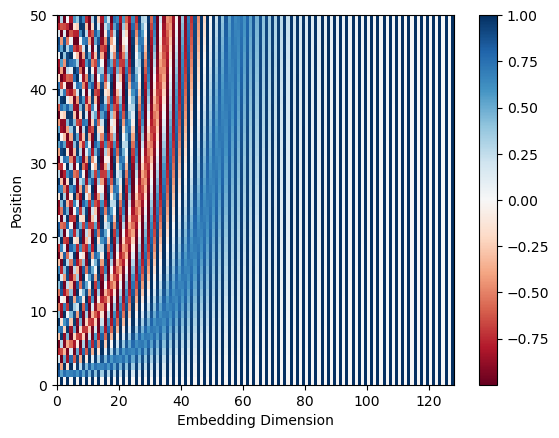

In [1]:
# 07장 트랜스포머/예제 7.01 위치 인코딩.ipynb

import math
import torch
from torch import nn
from matplotlib import pyplot as plt


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)


encoding = PositionalEncoding(d_model=128, max_len=50)

plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap="RdBu")
plt.xlabel("Embedding Dimension")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [2]:
# 07장 트랜스포머/예제 7.02~7.08 트랜스포머 모델 번역 결과.ipynb

!python -m spacy download de
!python -m spacy download en

C:\Users\Lenovo\anaconda3\envs\GDG_env\python.exe: No module named spacy
C:\Users\Lenovo\anaconda3\envs\GDG_env\python.exe: No module named spacy


In [4]:
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


def generate_tokens(text_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for text in text_iter:
        yield token_transform[language](text[language_index[language]])


SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

token_transform = {
    SRC_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"),
    TGT_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm"),
}
print("Token Transform:")
print(token_transform)

vocab_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[language] = build_vocab_from_iterator(
        generate_tokens(train_iter, language),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)

print("Vocab Transform:")
print(vocab_transform)

OSError: [WinError 127] 지정된 프로시저를 찾을 수 없습니다

In [5]:
import math
import torch
from torch import nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        emb_size,
        max_len,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward,
        dropout=0.1,
    ):
        super().__init__()
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            d_model=emb_size, max_len=max_len, dropout=dropout
        )
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )

In [6]:
from torch import optim


BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = optim.Adam(model.parameters())

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

NameError: name 'vocab_transform' is not defined

In [7]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def input_transform(token_ids):
    return torch.cat(
        (torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX]))
    )

def collator(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


text_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[language] = sequential_transforms(
        token_transform[language], vocab_transform[language], input_transform
    )

data_iter = Multi30k(split="valid", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
source_tensor, target_tensor = next(iter(dataloader))

print("(source, target):")
print(next(iter(data_iter)))

print("source_batch:", source_tensor.shape)
print(source_tensor)

print("target_batch:", target_tensor.shape)
print(target_tensor)

NameError: name 'SRC_LANGUAGE' is not defined

In [8]:
def generate_square_subsequent_mask(s):
    mask = (torch.triu(torch.ones((s, s), device=DEVICE)) == 1).transpose(0, 1)
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


target_input = target_tensor[:-1, :]
target_out = target_tensor[1:, :]

source_mask, target_mask, source_padding_mask, target_padding_mask = create_mask(
    source_tensor, target_input
)

print("source_mask:", source_mask.shape)
print(source_mask)
print("target_mask:", target_mask.shape)
print(target_mask)
print("source_padding_mask:", source_padding_mask.shape)
print(source_padding_mask)
print("target_padding_mask:", target_padding_mask.shape)
print(target_padding_mask)

NameError: name 'target_tensor' is not defined

In [9]:
def run(model, optimizer, criterion, split):
    model.train() if split == "train" else model.eval()
    data_iter = Multi30k(split=split, language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
    
    losses = 0
    for source_batch, target_batch in dataloader:
        source_batch = source_batch.to(DEVICE)
        target_batch = target_batch.to(DEVICE)

        target_input = target_batch[:-1, :]
        target_output = target_batch[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            source_batch, target_input
        )

        logits = model(
            src=source_batch,
            trg=target_input,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_padding_mask=src_padding_mask,
            tgt_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
        )

        optimizer.zero_grad()
        loss = criterion(logits.reshape(-1, logits.shape[-1]), target_output.reshape(-1))
        if split == "train":
            loss.backward()
            optimizer.step()
        losses += loss.item()

    return losses / len(list(dataloader))


for epoch in range(5):
    train_loss = run(model, optimizer, criterion, "train")
    val_loss = run(model, optimizer, criterion, "valid")
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

NameError: name 'model' is not defined

In [10]:
def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol):
    source_tensor = source_tensor.to(DEVICE)
    source_mask = source_mask.to(DEVICE)

    memory = model.encode(source_tensor, source_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        target_mask = generate_square_subsequent_mask(ys.size(0))
        target_mask = target_mask.type(torch.bool).to(DEVICE)

        out = model.decode(ys, memory, target_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(source_tensor.data).fill_(next_word)], dim=0
        )
        if next_word == EOS_IDX:
            break
    return ys


def translate(model, source_sentence):
    model.eval()
    source_tensor = text_transform[SRC_LANGUAGE](source_sentence).view(-1, 1)
    num_tokens = source_tensor.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, source_tensor, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX
    ).flatten()
    output = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:-1]
    return " ".join(output)


output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Eine Gruppe von Menschen steht vor einem Gebäude .")
print(output_oov)
print(output)

NameError: name 'model' is not defined

In [11]:
# 07장 트랜스포머/예제 7.09 문장 생성을 위한 GPT-2 모델의 구조.ipynb

from transformers import GPT2LMHeadModel


model = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path="gpt2")

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer
└ wte
└ wpe
└ drop
└ h
│  └ 0
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 1
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 2
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 3
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 4
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 5
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 6
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 7
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 8
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 9
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 10
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 11
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
└ ln_f
lm_head


In [12]:
# 07장 트랜스포머/예제 7.10 GPT-2를 이용한 문장 생성.ipynb

from transformers import pipeline


generator = pipeline(task="text-generation", model="gpt2")
outputs = generator(
    text_inputs="Machine learning is",
    max_length=20,
    num_return_sequences=3,
    pad_token_id=generator.tokenizer.eos_token_id
)
print(outputs)

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
operator torchvision::nms does not exist

In [13]:
# 07장 트랜스포머/예제 7.11~7.14 GPT-2 모델 실습.ipynb

import torch
from torchtext.datasets import CoLA
from transformers import AutoTokenizer
from torch.utils.data import DataLoader


def collator(batch, tokenizer, device):
    source, labels, texts = zip(*batch)
    tokenized = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    labels = torch.tensor(labels, dtype=torch.long).to(device)
    return input_ids, attention_mask, labels


train_data = list(CoLA(split="train"))
valid_data = list(CoLA(split="dev"))
test_data = list(CoLA(split="test"))

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

epochs = 3
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    collate_fn=lambda x: collator(x, tokenizer, device),
    shuffle=True,
)
valid_dataloader = DataLoader(
    valid_data, batch_size=batch_size, collate_fn=lambda x: collator(x, tokenizer, device)
)
test_dataloader = DataLoader(
    test_data, batch_size=batch_size, collate_fn=lambda x: collator(x, tokenizer, device)
)

print("Train Dataset Length :", len(train_data))
print("Valid Dataset Length :", len(valid_data))
print("Test Dataset Length :", len(test_data))

OSError: [WinError 127] 지정된 프로시저를 찾을 수 없습니다

In [14]:
from torch import optim
from transformers import GPT2ForSequenceClassification


model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2
).to(device)
model.config.pad_token_id = model.config.eos_token_id
optimizer = optim.Adam(model.parameters(), lr=5e-5)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [15]:
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss()
        val_loss, val_accuracy = 0.0, 0.0
        
        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits

            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids)
            
            val_loss += loss
            val_accuracy += accuracy
    
    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy


best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/GPT2ForSequenceClassification.pt")
        print("Saved the model weights")

NameError: name 'epochs' is not defined

In [16]:
model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",
    num_labels=2
).to(device)
model.config.pad_token_id = model.config.eos_token_id
model.load_state_dict(torch.load("../models/GPT2ForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [18]:
# 07장 트랜스포머/예제 7.15~7.17 BERT 모델 실습.ipynb

import numpy as np
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
df = pd.DataFrame(corpus.test).sample(20000, random_state=42)
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(train.head(5).to_markdown())
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler


def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    labels = torch.tensor(data.label.values, dtype=torch.long).to(device)
    return TensorDataset(input_ids, attention_mask, labels)


def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",
    do_lower_case=False
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])
from torch import optim
from transformers import BertForSequenceClassification


model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",
    num_labels=2
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss()
        val_loss, val_accuracy = 0.0, 0.0
        
        for input_ids, attention_mask, labels in dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids)
            
            val_loss += loss
            val_accuracy += accuracy
    
    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy


best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/BertForSequenceClassification.pt")
        print("Saved the model weights")
model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",
    num_labels=2
).to(device)
model.load_state_dict(torch.load("../models/BertForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

ModuleNotFoundError: No module named 'Korpora'

In [ ]:
# 07장 트랜스포머/예제 7.18~7.23 BART 모델 실습.ipynb

!pip install evaluate rouge_score absl-py
import numpy as np
from datasets import load_dataset


news = load_dataset("argilla/news-summary", split="test")
df = news.to_pandas().sample(5000, random_state=42)[["text", "prediction"]]
df["prediction"] = df["prediction"].map(lambda x: x[0]["text"])
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(f"Source News : {train.text.iloc[0][:200]}")
print(f"Summarization : {train.prediction.iloc[0][:50]}")
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")
import torch
from transformers import BartTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence


def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt",
        max_length=1024
    )
    labels = []
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    for target in data.prediction:
        labels.append(tokenizer.encode(target, return_tensors="pt").squeeze())
    labels = pad_sequence(labels, batch_first=True, padding_value=-100).to(device)
    return TensorDataset(input_ids, attention_mask, labels)



def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 8
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BartTokenizer.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])
from torch import optim
from transformers import BartForConditionalGeneration


model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)
import numpy as np
import evaluate


def calc_rouge(preds, labels):
    preds = preds.argmax(axis=-1)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge2 = rouge_score.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )
    return rouge2["rouge2"]

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss, val_rouge = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits
            loss = outputs.loss

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            rouge = calc_rouge(logits, label_ids)
            
            val_loss += loss
            val_rouge += rouge

    val_loss = val_loss / len(dataloader)
    val_rouge = val_rouge / len(dataloader)
    return val_loss, val_rouge

rouge_score = evaluate.load("rouge", tokenizer=tokenizer)
best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Rouge {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/BartForConditionalGeneration.pt")
        print("Saved the model weights")
model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)
model.load_state_dict(torch.load("../models/BartForConditionalGeneration.pt"))

test_loss, test_rouge_score = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test ROUGE-2 Score : {test_rouge_score:.4f}")
from transformers import pipeline


summarizer = pipeline(
    task="summarization",
    model=model,
    tokenizer=tokenizer,
    max_length=54,
    device="cpu"
)

for index in range(5):
    news_text = test.text.iloc[index]
    summarization = test.prediction.iloc[index]
    predicted_summarization = summarizer(news_text)[0]["summary_text"]
    print(f"정답 요약문 : {summarization}")
    print(f"모델 요약문 : {predicted_summarization}\n")

  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ------ --------------------------------- 3.9/25.1 MB 19.6 MB/s eta 0:00:02
   ------------- -------------------------- 8.7/25.1 MB 19.9 MB/s eta 0:00:01
   ------------------------ --------------- 15.2/25.1 MB 23.3 MB/s eta 0:00:01
   ------------------------------------- -- 23.6/25.1 MB 27.2 MB/s eta 0:00:01
   ---------------------------------------- 25.1/25.1 MB 24.1 MB/s eta 0:00:00
Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
Using cached attrs-24.2.

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20417 [00:00<?, ? examples/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Source News : DANANG, Vietnam (Reuters) - Russian President Vladimir Putin said on Saturday he had a normal dialogue with U.S. leader Donald Trump at a summit in Vietnam, and described Trump as civil, well-educated
Summarization : Putin says had useful interaction with Trump at Vi
Training Data Size : 3000
Validation Data Size : 1000
Testing Data Size : 1000


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

In [ ]:
# 07장 트랜스포머/예제 7.24~7.25 KoELECTRA 모델 실습.ipynb

import numpy as np
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
df = pd.DataFrame(corpus.test).sample(20000, random_state=42)
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(train.head(5).to_markdown())
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")
import torch
from transformers import ElectraTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler


def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    labels = torch.tensor(data.label.values, dtype=torch.long).to(device)
    return TensorDataset(input_ids, attention_mask, labels)


def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = ElectraTokenizer.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    do_lower_case=False,
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])
from torch import optim
from transformers import ElectraForSequenceClassification


model = ElectraForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    num_labels=2
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss()
        val_loss, val_accuracy = 0.0, 0.0
        
        for input_ids, attention_mask, labels in dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids)
            
            val_loss += loss
            val_accuracy += accuracy
    
    val_loss = val_loss/len(dataloader)
    val_accuracy = val_accuracy/len(dataloader)
    return val_loss, val_accuracy


best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/ElectraForSequenceClassification.pt")
        print("Saved the model weights")
model = ElectraForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    num_labels=2
).to(device)
model.load_state_dict(torch.load("../models/ElectraForSequenceClassification.pt"))

test_loss, test_accuracy = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

In [ ]:
# 07장 트랜스포머/예제 7.26~7.30 T5 모델 실습.ipynb

import numpy as np
from datasets import load_dataset


news = load_dataset("argilla/news-summary", split="test")
df = news.to_pandas().sample(5000, random_state=42)[["text", "prediction"]]
df["text"] = "summarize: " + df["text"]
df["prediction"] = df["prediction"].map(lambda x: x[0]["text"])
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

print(f"Source News : {train.text.iloc[0][:200]}")
print(f"Summarization : {train.prediction.iloc[0][:50]}")
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")
import torch
from transformers import T5Tokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence


def make_dataset(data, tokenizer, device):
    source = tokenizer(
        text=data.text.tolist(),
        padding="max_length",
        max_length=128,
        pad_to_max_length=True,
        truncation=True,
        return_tensors="pt"
    )

    target = tokenizer(
        text=data.prediction.tolist(),
        padding="max_length", 
        max_length=128,
        pad_to_max_length=True,
        truncation=True,
        return_tensors="pt"
    )
    
    source_ids = source["input_ids"].squeeze().to(device)
    source_mask = source["attention_mask"].squeeze().to(device)
    target_ids = target["input_ids"].squeeze().to(device)
    target_mask = target["attention_mask"].squeeze().to(device)
    return TensorDataset(source_ids, source_mask, target_ids, target_mask)

def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader


epochs = 5
batch_size = 8
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path="t5-small"
)

train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(next(iter(train_dataloader)))
print(tokenizer.convert_ids_to_tokens(21603))
print(tokenizer.convert_ids_to_tokens(10))
from torch import optim
from transformers import T5ForConditionalGeneration


model = T5ForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="t5-small",
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
import numpy as np
from torch import nn


def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for source_ids, source_mask, target_ids, target_mask in dataloader:
        decoder_input_ids = target_ids[:, :-1].contiguous()
        labels = target_ids[:, 1:].clone().detach()
        labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100

        outputs = model(
            input_ids=source_ids,
            attention_mask=source_mask,
            decoder_input_ids=decoder_input_ids,
            labels=labels,
        )

        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss


def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss = 0.0

        for source_ids, source_mask, target_ids, target_mask in dataloader:
            decoder_input_ids = target_ids[:, :-1].contiguous()
            labels = target_ids[:, 1:].clone().detach()
            labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100

            outputs = model(
                input_ids=source_ids,
                attention_mask=source_mask,
                decoder_input_ids=decoder_input_ids,
                labels=labels,
            )

            loss = outputs.loss
            val_loss += loss

    val_loss = val_loss / len(dataloader)
    return val_loss


best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/T5ForConditionalGeneration.pt")
        print("Saved the model weights")
model.eval()
with torch.no_grad():
    for source_ids, source_mask, target_ids, target_mask in test_dataloader:
        generated_ids = model.generate(
            input_ids=source_ids,
            attention_mask=source_mask,
            max_length=128,
            num_beams=3,
            repetition_penalty=2.5,
            length_penalty=1.0,
            early_stopping=True,
        )

        for generated, target in zip(generated_ids, target_ids):
            pred = tokenizer.decode(
                generated, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            actual = tokenizer.decode(
                target, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            print("Generated Headline Text:", pred) 
            print("Actual Headline Text   :", actual) 
        break